In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb


import warnings
import pickle
warnings.filterwarnings("ignore")



from src.data_assemble.assemble_ml import *
from src.models.utils import *

In [3]:
start = '2006-01-01'
end = '2016-01-01'
df = pd.read_csv('data_meteo_kk.csv')
st = pd.read_csv('weatherstation_list.csv')
loaded_arr = np.loadtxt("wind_in_box.txt")  
# This loadedArr is a 2D array, therefore, we need to convert it to the original array shape.reshaping to get original matrice with original shape.
cmip = loaded_arr.reshape(3652, 15, 22)

In [4]:
include_day_ohe = False
single_day = False
speed_th = 20
if single_day:
    X_an, y_an = make_ds(start, end, 'Анапа', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #310
    X_ar, y_ar = make_ds(start, end, 'Армавир', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #75
    X_kr, y_kr = make_ds(start, end, 'Краснодар, Круглик', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #38
    X_so, y_so = make_ds(start, end, 'Сочи', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #28
    X_tu, y_tu = make_ds(start, end, 'Туапсе', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #160
    X_pr, y_pr = make_ds(start, end, 'Приморско-Ахтарск', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #163
    X_kp, y_kp = make_ds(start, end, 'Красная Поляна', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) 
else:
    # X_an_d, y_an_d = dss(start, end, 'Анапа', st, df, 15, include_day_ohe=include_day_ohe) #310

    X_an, y_an = dss(start, end, 'Анапа', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #310
    X_ar, y_ar = dss(start, end, 'Армавир', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #75
    X_kr, y_kr = dss(start, end, 'Краснодар, Круглик', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #38
    X_so, y_so = dss(start, end, 'Сочи', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #28
    X_tu, y_tu = dss(start, end, 'Туапсе', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #160
    X_pr, y_pr = dss(start, end, 'Приморско-Ахтарск', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #163
    X_kp, y_kp = dss(start, end, 'Красная Поляна', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) 

In [5]:
dataset_stations = [(X_an, y_an), (X_ar, y_ar), (X_kr, y_kr), (X_so, y_so), (X_tu, y_tu), (X_pr, y_pr), (X_kp, y_kp)]
dataset_stations = [s for s in dataset_stations if len(s[0]) == len(s[1])]

In [6]:
clf = xgb.XGBClassifier(n_jobs=-1, eta=1e-1, scale_pos_weight = 1 / np.mean(dataset_stations[1][1]), max_depth=4)

In [7]:
# parameters = {'eta': [1e-4, 1e-3, 1e-2, 1e-1], 'max_depth': range(1,7)}
# grid = GridSearchCV(clf, parameters, cv=5)
X_train, y_train, X_test, y_test = get_split_train_test(dataset_stations, split_ratio=0.4)
# grid.fit(X_train, y_train)
# grid.best_params_
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=72.76, seed=None, silent=True,
       subsample=1)

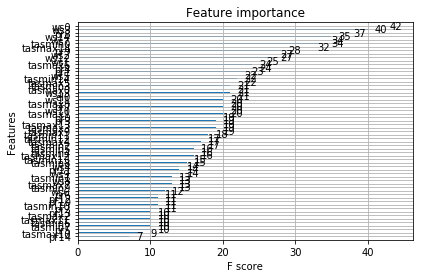

In [8]:
# plt.rcParams["figure.figsize"] = (14, 10)
ns = ["pr", "tasmin", "tasmax", "ws", "el"]
fnames_ = [[n + str(i) for n in ns]for i in range(len(X_train[0]) // 5)]
fnames = []
for f in fnames_:
    for f_ in f:
        fnames.append(f_)
clf.get_booster().feature_names = fnames
xgb.plot_importance(clf)
plt.show()

clf.get_booster().feature_names = ["f" + str(i) for i in range(X_train.shape[1])]

In [76]:

filename = 'model_wind.sav'
pickle.dump(clf, open(filename, 'wb'))


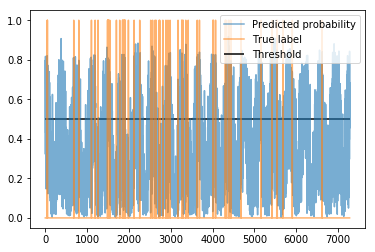

In [9]:
plt.plot(clf.predict_proba(X_test)[:,1], label='Predicted probability', alpha=0.6)
plt.plot(y_test, label='True label', alpha=0.6)
plt.hlines(y=0.5, xmin=0, xmax=len(y_test), label='Threshold')
plt.legend()

No Skill: ROC AUC=0.500
Clf: ROC AUC=0.741


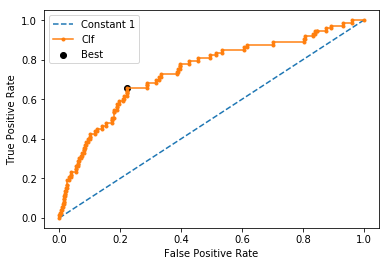

Best Threshold=0.557174, G-Mean=0.714
[[5161 2042]
 [  25   48]]


[0.715915338097856,
 0.022966507177033493,
 0.6575342465753424,
 0.044382801664355064,
 0.7411067306430541]

In [10]:
metrics(clf,X_test, y_test, True)

No Skill: ROC AUC=0.500
Clf: ROC AUC=0.974


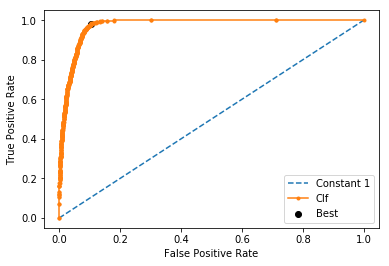

Best Threshold=0.720577, G-Mean=0.938
[[9732 4334]
 [   0  486]]


[0.7021715228147334,
 0.1008298755186722,
 1.0,
 0.18318884281944967,
 0.9741263847856577]

In [11]:
metrics(clf,X_train, y_train, True)

In [54]:
filename = 'model.sav'
pickle.dump(clf, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
# X_train, y_train, X_test, y_test = get_split_train_test(dataset_stations, 0.4)
# clf.score(X_test, y_test)
# loaded_model.score(X_test, y_test)

False